In [1]:
from cytograph import Algorithm, creates, requires, div0
from cytograph.visualization.scatter import scatterc, scattern
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from typing import List
import shoji
import cytograph as cg
import cytograph.visualization as cgplot
import collections
from typing import List, Optional
import matplotlib.patheffects as PathEffects
import fastcluster
import igraph
import leidenalg as la
import scipy.cluster.hierarchy as hc
from hmmlearn import hmm
from openTSNE import TSNE
from pynndescent import NNDescent
from scipy.spatial.distance import pdist
from sklearn.decomposition import PCA
from tqdm import trange
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
from cytograph.visualization import Colorizer
from matplotlib.lines import Line2D
import scanpy as sc
import loompy
import infercnvpy as cnv

In [2]:
db = shoji.connect()

In [3]:
ws = db.builds.jesper.GBM_all.SL040

In [23]:
Z = ["#ffe5cc", # Cortex - gray
 "royalblue", #Periphery - blue
 "#B15297", #Low - purple
"deeppink", #High - pink
 "#000000"] #Necrotic core - black

In [24]:
col = []
FL = ws.Fluorescence[:]
for x in FL:
    if x == 'Cortex':
        col.append(Z[0])
    elif x == 'Periphery':
        col.append(Z[1])
    elif x == 'Low':
        col.append(Z[2])
    elif x == 'High':
        col.append(Z[3])
    else:
        col.append(Z[4])

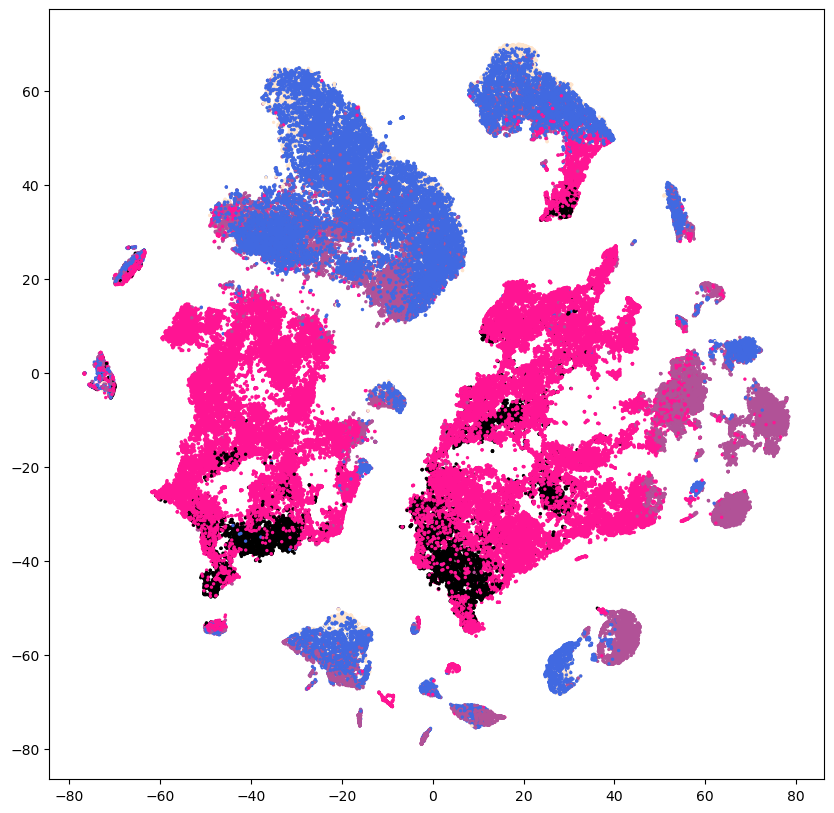

In [293]:
plt.figure(figsize=(10,10))
plt.scatter(ws.Embedding[:, 0], ws.Embedding[:, 1], c=col, s=6, lw=0, rasterized=True)
plt.savefig("/proj/cytograph/jesper/Figures/Fig1_SL040/SL040_colors_zones_new.pdf", dpi=300, bbox_inches="tight")

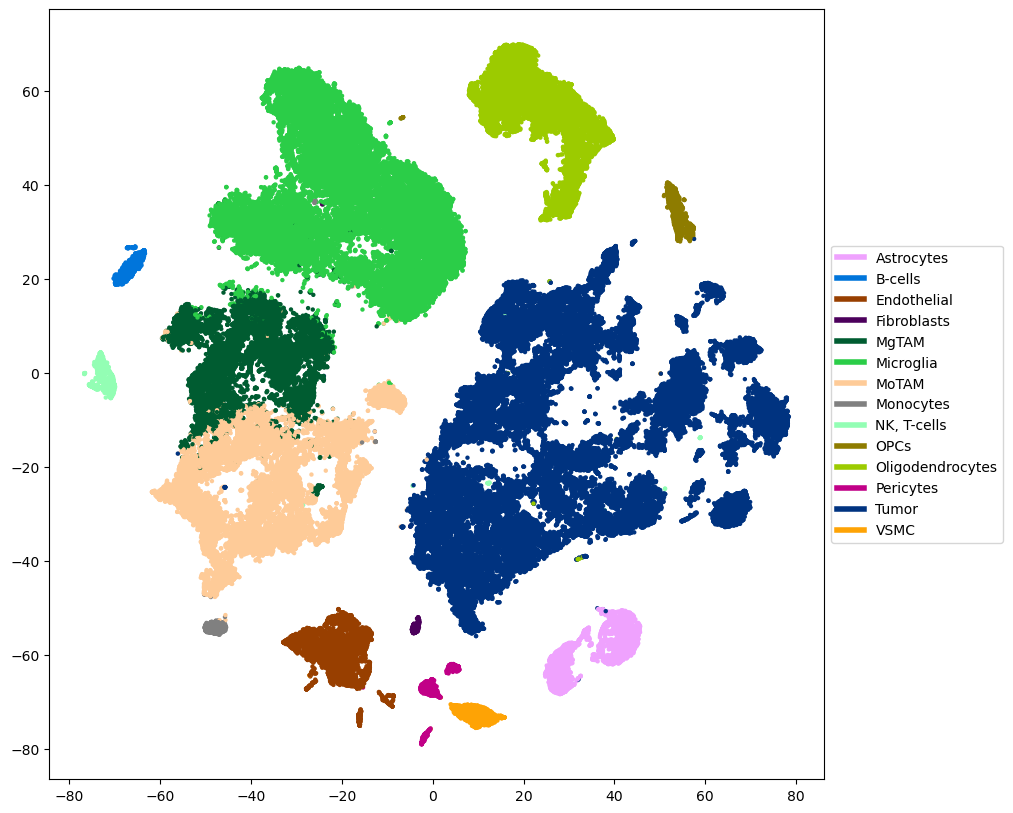

In [142]:
ws = db.builds.jesper.GBM_all.SL040
plt.figure(figsize=(10,10))
cgplot.scatterc(ws.Embedding[:], c=ws.ManualAnnotationSL040[:], s=10)
plt.savefig("/proj/cytograph/jesper/Fig1_jesper/Fig1_SL040/SL040_Annotation.pdf", dpi=300)

In [4]:
labels2 = [
    'Monocytes',
    'Macrophages',
    'moTAM',
    'mgTAM',
    'Microglia',
    'Oligodendrocytes',
    'Astrocytes',
    'Tumor',
    'Other']

In [6]:
Right_order = ['Monocytes','Macrophages','MoTAM','MgTAM','Microglia','Oligodendrocytes','Astrocytes']

In [7]:
Z =["#a580ad",
    "#c7bd80",
[0.99609375, 0.796875, 0.59765625],
 "#b36305", 
"#ee7c0e",
"#000000",
'#4574b3',
 "#74c493", 
"#bfbfbf"]

In [301]:
col = []
FL = ws.ManualAnnotationSL040_MAC[:]
for x in FL:
    if x == 'Monocytes':
        col.append(Z[0])
    elif x == 'Macrophages':
        col.append(Z[1])
    elif x == 'MoTAM':
        col.append(Z[2])
    elif x == 'MgTAM':
        col.append(Z[3])
    elif x == 'Microglia':
        col.append(Z[4])
    elif x == 'Oligodendrocytes':
        col.append(Z[5])
    elif x == 'Astrocytes':
        col.append(Z[6])
    elif x == 'Tumor':
        col.append(Z[7])
    else:
        col.append(Z[8])

In [8]:
palette_classes = {'Astrocytes':'#4574b3',
 'B-cells': [0.0, 0.45703125, 0.859375],
 'Endothelial': [0.59765625, 0.24609375, 0.0],
 'Fibroblasts': [0.296875, 0.0, 0.359375],
 'Macrophages': "#c7bd80",
 'Microglia': "#ee7c0e",
 'MoTAM': [0.99609375, 0.796875, 0.59765625], 
 'MgTAM':  "#b36305",                
 'Monocytes': "#a580ad",
 'OPCs': [0.55859375, 0.484375, 0.0],
 'Oligodendrocytes': "#000000",
 'Pericytes': [0.7578125, 0.0, 0.53125],
 'Tumor': "#74c493",
 'VSMC': [0.99609375, 0.640625, 0.01953125]}

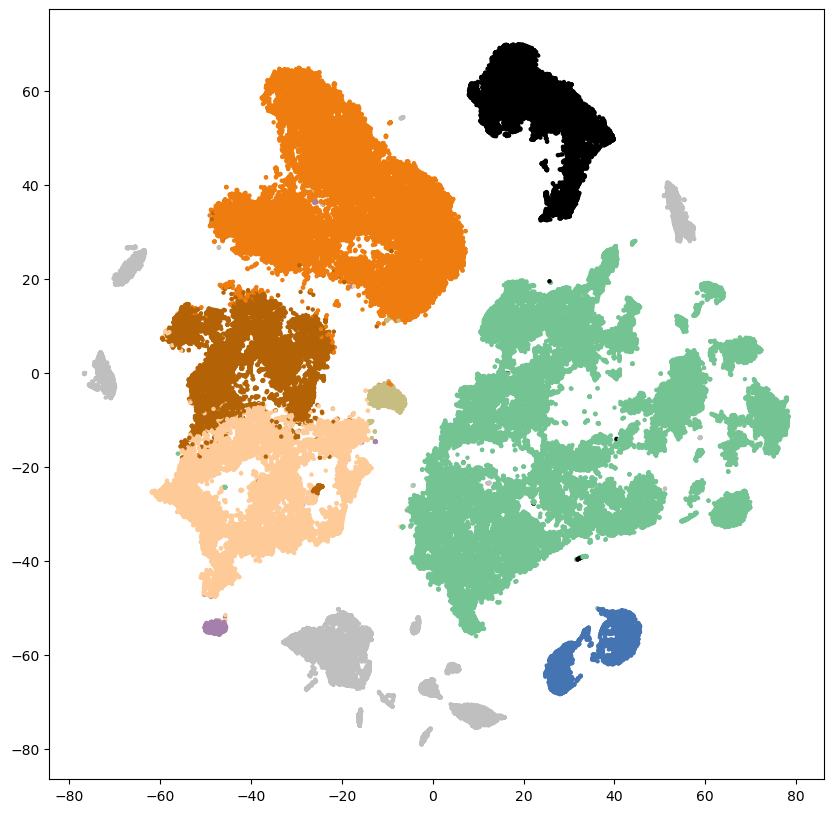

In [303]:
plt.figure(figsize=(10,10))
plt.scatter(ws.Embedding[:, 0], ws.Embedding[:, 1], c=col, s=10, lw=0, rasterized=True)
plt.savefig("/proj/cytograph/jesper/Figures/Fig1_SL040/SL040_tSNE_colors_new.pdf", dpi=300, bbox_inches="tight")

CPU times: user 8.93 s, sys: 2.15 s, total: 11.1 s
Wall time: 14.8 s


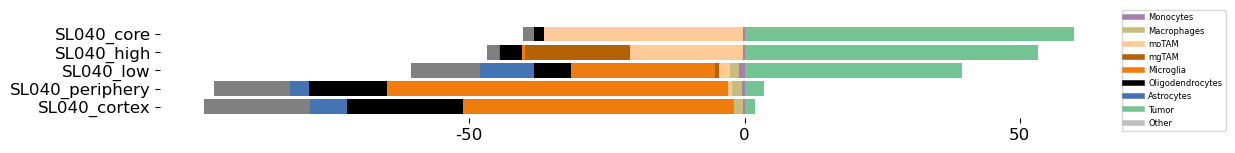

In [283]:
%%time
S = []
#Samples = np.unique(ws.Zone[:])
ws = db.builds.jesper.GBM_all.SL040
Samples = ['Necrotic core', 'High', 'Low', 'Periphery', 'Cortex']
unique_samples = ['SL040_core', 'SL040_high', 'SL040_low', 'SL040_periphery', 'SL040_cortex']
unique_samples = np.flip(unique_samples)
Samples = np.flip(Samples)
Samples = np.array(Samples, dtype=object)
unique_samples = np.array(unique_samples, dtype=object)
labels = np.unique(ws.ManualAnnotationSL040_MAC[:])
for i, sample in enumerate(Samples):
    Man = ws.ManualAnnotationSL040_MAC[:][ws.Fluorescence[:] == sample]
    Sum = []
    for x in labels:
        Sum.append(np.sum(np.isin(Man, x)))
    Percent = []
    tot = np.sum(Sum)
    for x in Sum:
        roundedNumber = round(x/tot * 100, 3)
        Perc = str(roundedNumber) + "%"
        Percent.append(roundedNumber)
    size = np.array(Percent)
    S.append(size)
df = pd.DataFrame(S, columns=labels,  index=unique_samples)
nontumor_bars = df.drop(['B-cells','Endothelial','Fibroblasts','NK, T-cells','OPCs','Pericytes','VSMC','Tumor'], axis=1)
other_bars = df[['B-cells','Endothelial','Fibroblasts','NK, T-cells','OPCs','Pericytes','VSMC']]
tumor_bars = df[["Tumor"]]
left = np.zeros(len(unique_samples))
#fig, axes = plt.subplots(figsize=(2, 10) , nrows = 2, ncols = 1,sharex=True, gridspec_kw={'height_ratios': [2, 2 ]})
fig, ax1 = plt.subplots(figsize=(10, 1.25))
fig.tight_layout(pad=0)
#ax1 = axes[0]
#ax1.axis('off')
ax1.spines[['top','bottom','left', 'right']].set_visible(False)
ax1.set_xticks([-50,0,50])
ax1.xaxis.set_visible(True) 
#ax1.yaxis.set_visible(True) 

ax1.set_xticklabels([-50,0,50],fontsize=12)

for i, ct in enumerate(Right_order):
    #ax1.bar(unique_samples,height=-nontumor_bars[ct],bottom=-bottom, color=palette_classes[ct])
    #bottom += nontumor_bars[ct]
    ax1.barh(unique_samples,height=0.8, width=-nontumor_bars[ct],left=-left, color=palette_classes[ct])
    left += nontumor_bars[ct]
for i, ct in enumerate(other_bars):
    #ax1.bar(unique_samples,height=-other_bars[ct],bottom=-bottom, color=[0.5, 0.5, 0.5])
    #bottom += other_bars[ct]
    ax1.barh(unique_samples,height=0.8, width=-other_bars[ct],left=-left, color=[0.5, 0.5, 0.5])
    left += other_bars[ct]
for i, ct in enumerate(tumor_bars):
    #ax1.bar(unique_samples,height=tumor_bars[ct],bottom=0, color=palette_classes[ct])
    ax1.barh(unique_samples, height=0.8, width=tumor_bars[ct],left=0, color=palette_classes[ct])
hidden_lines = [Line2D([0], [0], color=clr, lw=4) for clr in Z]
ax1.legend(hidden_lines,labels2, loc='center left', bbox_to_anchor=(1, 0.5),fontsize=6)
ax1.set_yticklabels(unique_samples, fontsize=12)
plt.savefig("/proj/cytograph/jesper/Figures/Fig1_SL040/SL040_colors_new.pdf", dpi=300, bbox_inches="tight")
#plt.show()

CPU times: user 20.9 s, sys: 5.38 s, total: 26.2 s
Wall time: 34.2 s


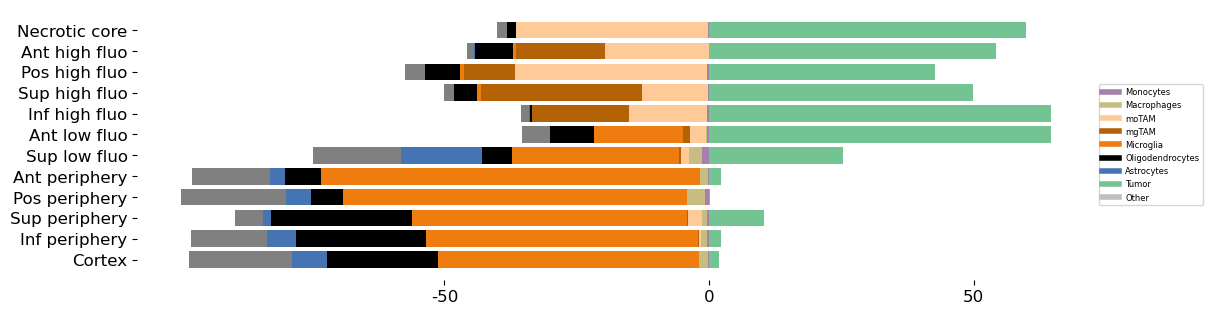

In [15]:
%%time
S = []
#Samples = np.unique(ws.Zone[:])
ws = db.builds.jesper.GBM_all.SL040
Samples = ['Necrotic core',
           'Ant high fluo', 'Pos high fluo','Sup high fluo', 'Inf high fluo',
           'Ant low fluo', 'Sup low fluo',
           'Ant periphery','Pos periphery','Sup periphery','Inf periphery', 
           'Cortex'
          ]
labels = np.unique(ws.ManualAnnotationSL040_MAC[:])
Samples = np.flip(Samples)
Samples = np.array(Samples, dtype=object)
unique_samples = Samples
for i, sample in enumerate(Samples):
    Man = ws.ManualAnnotationSL040_MAC[:][ws.Location[:] == sample]
    Sum = []
    for x in labels:
        Sum.append(np.sum(np.isin(Man, x)))
    Percent = []
    tot = np.sum(Sum)
    for x in Sum:
        roundedNumber = round(x/tot * 100, 3)
        Perc = str(roundedNumber) + "%"
        Percent.append(roundedNumber)
    size = np.array(Percent)
    S.append(size)
df = pd.DataFrame(S, columns=labels,  index=unique_samples)
nontumor_bars = df.drop(['B-cells','Endothelial','Fibroblasts','NK, T-cells','OPCs','Pericytes','VSMC','Tumor'], axis=1)
other_bars = df[['B-cells','Endothelial','Fibroblasts','NK, T-cells','OPCs','Pericytes','VSMC']]
tumor_bars = df[["Tumor"]]
left = np.zeros(len(unique_samples))
#fig, axes = plt.subplots(figsize=(2, 10) , nrows = 2, ncols = 1,sharex=True, gridspec_kw={'height_ratios': [2, 2 ]})
fig, ax1 = plt.subplots(figsize=(10, len(Samples)*0.25))
fig.tight_layout(pad=0)
#ax1 = axes[0]
#ax1.axis('off')
ax1.spines[['top','bottom','left', 'right']].set_visible(False)
ax1.set_xticks([-50,0,50])
ax1.xaxis.set_visible(True) 
#ax1.yaxis.set_visible(True) 

ax1.set_xticklabels([-50,0,50],fontsize=12)

for i, ct in enumerate(Right_order):
    #ax1.bar(unique_samples,height=-nontumor_bars[ct],bottom=-bottom, color=palette_classes[ct])
    #bottom += nontumor_bars[ct]
    ax1.barh(unique_samples,height=0.8, width=-nontumor_bars[ct],left=-left, color=palette_classes[ct])
    left += nontumor_bars[ct]
for i, ct in enumerate(other_bars):
    #ax1.bar(unique_samples,height=-other_bars[ct],bottom=-bottom, color=[0.5, 0.5, 0.5])
    #bottom += other_bars[ct]
    ax1.barh(unique_samples,height=0.8, width=-other_bars[ct],left=-left, color=[0.5, 0.5, 0.5])
    left += other_bars[ct]
for i, ct in enumerate(tumor_bars):
    #ax1.bar(unique_samples,height=tumor_bars[ct],bottom=0, color=palette_classes[ct])
    ax1.barh(unique_samples, height=0.8, width=tumor_bars[ct],left=0, color=palette_classes[ct])
hidden_lines = [Line2D([0], [0], color=clr, lw=4) for clr in Z]
ax1.legend(hidden_lines,labels2, loc='center left', bbox_to_anchor=(1, 0.5),fontsize=6)
ax1.set_yticklabels(unique_samples, fontsize=12) 
#plt.show()
None
plt.savefig("/proj/cytograph/jesper/Figures/Fig1_SL040/SL040_colors_new_all_directions.pdf", dpi=300, bbox_inches="tight")

In [26]:
tumor_bars

,Tumor
Cortex,1.82
Inf periphery,2.21
Sup periphery,10.42
Pos periphery,0.21
Ant periphery,2.25
Sup low fluo,25.20
Ant low fluo,64.56
Inf high fluo,64.54
Sup high fluo,49.89
Pos high fluo,42.61


CPU times: user 19.4 s, sys: 5.01 s, total: 24.4 s
Wall time: 34.1 s


[Text(0, 0, 'Cortex'),
 Text(0, 1, 'Inf periphery'),
 Text(0, 2, 'Sup periphery'),
 Text(0, 3, 'Pos periphery'),
 Text(0, 4, 'Ant periphery'),
 Text(0, 5, 'Sup low fluo'),
 Text(0, 6, 'Ant low fluo'),
 Text(0, 7, 'Inf high fluo'),
 Text(0, 8, 'Sup high fluo'),
 Text(0, 9, 'Pos high fluo'),
 Text(0, 10, 'Ant high fluo'),
 Text(0, 11, 'Necrotic core')]

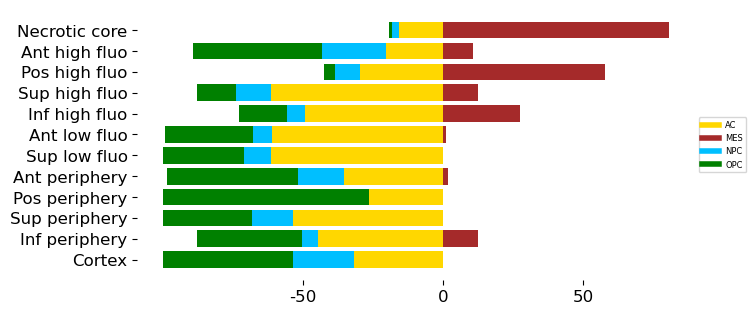

In [18]:
%%time
S = []
#Samples = np.unique(ws.Zone[:])
ws = db.builds.jesper.GBM_all.SL040
Samples = ['Necrotic core',
           'Ant high fluo', 'Pos high fluo','Sup high fluo', 'Inf high fluo',
           'Ant low fluo', 'Sup low fluo',
           'Ant periphery','Pos periphery','Sup periphery','Inf periphery', 
           'Cortex'
          ]
Samples = np.flip(Samples)
unique_samples = Samples
Samples = np.array(Samples, dtype=object)
A = ['AC', 'MES', 'NPC', 'OPC']
labels = np.array(A, dtype=object)
for i, sample in enumerate(Samples):
    ac, mes, npc, opc = np.hsplit(ws.NeftelScore[ws.Location[:] == sample][ws.ManualAnnotationSL040[ws.Location[:] == sample] == 'Tumor'], 4)
    winnersAll = np.argmax([ac, mes, npc, opc], axis=0)
    Man = np.hstack(labels[winnersAll])
    Sum = []
    for x in labels:
        Sum.append(np.sum(np.isin(Man, x)))
    Percent = []
    tot = np.sum(Sum)
    for x in Sum:
        roundedNumber = round(x/tot * 100, 3)
        Perc = str(roundedNumber) + "%"
        Percent.append(roundedNumber)
    size = np.array(Percent)
    S.append(size)
df = pd.DataFrame(S, columns=labels,  index=unique_samples)
nontumor_bars = df.drop('MES', axis=1)
tumor_bars = df[["MES"]]
left = np.zeros(len(unique_samples))
#fig, axes = plt.subplots(figsize=(2, 10) , nrows = 2, ncols = 1,sharex=True, gridspec_kw={'height_ratios': [2, 2 ]})
fig, ax1 = plt.subplots(figsize=(6, len(Samples)*0.25))
fig.tight_layout(pad=0)
#ax1 = axes[0]
#ax1.axis('off')
ax1.spines[['top','bottom','left', 'right']].set_visible(False)
ax1.set_xticks([-50,0,50])
ax1.xaxis.set_visible(True) 
#ax1.yaxis.set_visible(True) 

ax1.set_xticklabels([-50,0,50],fontsize=12)
colors=["gold", "brown", "deepskyblue", "green"]
pcolors = dict(zip(labels, colors))

for i, ct in enumerate(nontumor_bars):
    #ax1.bar(unique_samples,height=-nontumor_bars[ct],bottom=-bottom, color=palette_classes[ct])
    #bottom += nontumor_bars[ct]
    ax1.barh(unique_samples,height=0.8, width=-nontumor_bars[ct],left=-left, color=pcolors[ct])
    left += nontumor_bars[ct]
for i, ct in enumerate(tumor_bars):
    #ax1.bar(unique_samples,height=tumor_bars[ct],bottom=0, color=palette_classes[ct])
    ax1.barh(unique_samples, height=0.8, width=tumor_bars[ct],left=0, color=pcolors[ct])
hidden_lines = [Line2D([0], [0], color=clr, lw=4) for clr in colors]
ax1.legend(hidden_lines,labels, loc='center left', bbox_to_anchor=(1, 0.5),fontsize=6)
ax1.set_yticklabels(unique_samples, fontsize=12) 
#plt.show()
plt.savefig("/proj/cytograph/jesper/Figures/Fig1_SL040/SL040_BarHorizontal_MetaModules_fraction_tumorcells__Separate_Samples_label.pdf", dpi=300, bbox_inches="tight")

CPU times: user 9.18 s, sys: 2.27 s, total: 11.4 s
Wall time: 14.4 s


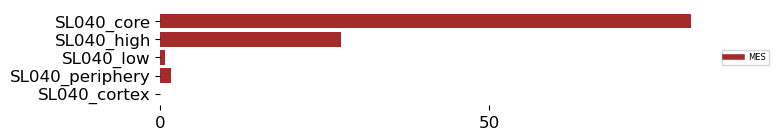

In [311]:
%%time
S = []
#Samples = np.unique(ws.Zone[:])
ws = db.builds.jesper.GBM_all.SL040
Samples = ['Necrotic core', 'High', 'Low', 'Periphery','Cortex']
unique_samples = ['SL040_core', 'SL040_high', 'SL040_low', 'SL040_periphery', 'SL040_cortex']
Samples = np.array(Samples, dtype=object)
Samples = np.flip(Samples)
unique_samples = np.array(unique_samples, dtype=object)
unique_samples = np.flip(unique_samples)
A = ['AC', 'MES', 'NPC', 'OPC']
labels = np.array(A, dtype=object)
for i, sample in enumerate(Samples):
    ac, mes, npc, opc = np.hsplit(ws.NeftelScore[ws.Fluorescence[:] == sample][ws.ManualAnnotationSL040[ws.Fluorescence[:] == sample] == 'Tumor'], 4)
    winnersAll = np.argmax([ac, mes, npc, opc], axis=0)
    Man = np.hstack(labels[winnersAll])
    Sum = []
    for x in labels:
        Sum.append(np.sum(np.isin(Man, x)))
    Percent = []
    tot = np.sum(Sum)
    for x in Sum:
        roundedNumber = round(x/tot * 100, 3)
        Perc = str(roundedNumber) + "%"
        Percent.append(roundedNumber)
    size = np.array(Percent)
    S.append(size)
df = pd.DataFrame(S, columns=labels,  index=unique_samples)
nontumor_bars = df.drop('MES', axis=1)
tumor_bars = df[["MES"]]
left = np.zeros(len(unique_samples))
#fig, axes = plt.subplots(figsize=(2, 10) , nrows = 2, ncols = 1,sharex=True, gridspec_kw={'height_ratios': [2, 2 ]})
fig, ax1 = plt.subplots(figsize=(6, len(Samples)*0.25))
fig.tight_layout(pad=0)
#ax1 = axes[0]
#ax1.axis('off')
ax1.spines[['top','bottom','left', 'right']].set_visible(False)
ax1.set_xticks([-50,0,50])
ax1.xaxis.set_visible(True) 
#ax1.yaxis.set_visible(True) 

ax1.set_xticklabels([-50,0,50],fontsize=12)
colors=["brown"]
labels = ['MES']
labels = np.array(labels, dtype=object)
pcolors = dict(zip(labels, colors))

#for i, ct in enumerate(nontumor_bars):
    #ax1.bar(unique_samples,height=-nontumor_bars[ct],bottom=-bottom, color=palette_classes[ct])
    #bottom += nontumor_bars[ct]
#    ax1.barh(unique_samples,height=0.8, width=-nontumor_bars[ct],left=-left, color=pcolors[ct])
#    left += nontumor_bars[ct]
for i, ct in enumerate(tumor_bars):
    #ax1.bar(unique_samples,height=tumor_bars[ct],bottom=0, color=palette_classes[ct])
    ax1.barh(unique_samples, height=0.8, width=tumor_bars[ct],left=0, color=pcolors[ct])
hidden_lines = [Line2D([0], [0], color=clr, lw=4) for clr in colors]
ax1.legend(hidden_lines,labels, loc='center left', bbox_to_anchor=(1, 0.5),fontsize=6)
ax1.set_yticklabels(unique_samples, fontsize=12) 
plt.savefig("/proj/cytograph/jesper/Figures/Fig1_SL040/SL040_BarHorizontal_MESonly_fraction_cells.pdf", dpi=300, bbox_inches="tight")#

CPU times: user 18 s, sys: 4.41 s, total: 22.4 s
Wall time: 28.5 s


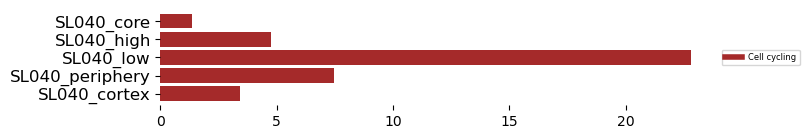

In [310]:
%%time
S = []
ws = db.builds.jesper.GBM_all.SL040
Samples = ['Necrotic core', 'High', 'Low', 'Periphery','Cortex']
unique_samples = ['SL040_core', 'SL040_high', 'SL040_low', 'SL040_periphery', 'SL040_cortex']
Samples = np.array(Samples, dtype=object)
Samples = np.flip(Samples)
unique_samples = np.array(unique_samples, dtype=object)
unique_samples = np.flip(unique_samples)
for i, sample in enumerate(Samples):
    Man = np.sum(ws.CellCycleFraction[ws.Fluorescence[:] == sample][ws.ManualAnnotationSL040[ws.Fluorescence[:] == sample] == 'Tumor'] > 0.004)
    tot = len(ws.CellCycleFraction[ws.Fluorescence[:] == sample][ws.ManualAnnotationSL040[ws.Fluorescence[:] == sample] == 'Tumor'])
    roundedNumber = round(Man/tot * 100, 3)
    Perc = str(roundedNumber) + "%"
    #Percent.append(roundedNumber)
    #size = np.array(Percent)
    S.append(roundedNumber)
tumor_bars = pd.DataFrame(S, index=unique_samples)
tumor_bars = tumor_bars.rename(columns={0: 'Cell cycling'})
left = np.zeros(len(unique_samples))
#fig, axes = plt.subplots(figsize=(2, 10) , nrows = 2, ncols = 1,sharex=True, gridspec_kw={'height_ratios': [2, 2 ]})
fig, ax1 = plt.subplots(figsize=(6, len(Samples)*0.25))
fig.tight_layout(pad=0)
#ax1 = axes[0]
#ax1.axis('off')
ax1.spines[['top','bottom','left', 'right']].set_visible(False)
#ax1.set_xticks([-50,0,50])
ax1.xaxis.set_visible(True) 
#ax1.yaxis.set_visible(True) 
#ax1.set_xticklabels([-50,0,50],fontsize=12)
colors=["brown"]
labels = ['Cell cycling']
labels = np.array(labels, dtype=object)
pcolors = dict(zip(labels, colors))

#for i, ct in enumerate(nontumor_bars):
    #ax1.bar(unique_samples,height=-nontumor_bars[ct],bottom=-bottom, color=palette_classes[ct])
    #bottom += nontumor_bars[ct]
#    ax1.barh(unique_samples,height=0.8, width=-nontumor_bars[ct],left=-left, color=pcolors[ct])
#    left += nontumor_bars[ct]
for i, ct in enumerate(tumor_bars):
    #ax1.bar(unique_samples,height=tumor_bars[ct],bottom=0, color=palette_classes[ct])
    ax1.barh(unique_samples, height=0.8, width=tumor_bars[ct],left=0, color=pcolors[ct])
hidden_lines = [Line2D([0], [0], color=clr, lw=4) for clr in colors]
ax1.legend(hidden_lines,labels, loc='center left', bbox_to_anchor=(1, 0.5),fontsize=6)
ax1.set_yticklabels(unique_samples, fontsize=12) 
plt.savefig("/proj/cytograph/jesper/Figures/Fig1_SL040/SL040_BarHorizontal_cycling_fraction_cells_cortex.pdf", dpi=300,  bbox_inches="tight")

In [9]:
MES1 = np.array(["CHI3L1","ANXA2","ANXA1","CD44","VIM","MT2A","C1S","NAMPT","EFEMP1","C1R","SOD2","IFITM3","TIMP1","SPP1","A2M","S100A11","MT1X","S100A10","FN1","LGALS1","S100A16","CLIC1","MGST1","RCAN1","TAGLN2","NPC2","SERPING1","TCIM","EMP1","APOE","CTSB","C3","LGALS3","MT1E","EMP3","SERPINA3","ACTN1","PRDX6","IGFBP7","SERPINE1","PLP2","MGP","CLIC4","GFPT2","GSN","NNMT","TUBA1C","GJA1","TNFRSF1A","WWTR1"])
MES2 = np.array(["HILPDA","ADM","DDIT3","NDRG1","HERPUD1","DNAJB9","TRIB3","ENO2","AKAP12","SQSTM1","MT1X","ATF3","NAMPT","NRN1","SLC2A1","BNIP3","LGALS3","INSIG2","IGFBP3","PPP1R15A","VIM","PLOD2","GBE1","SLC2A3","FTL","WARS1","ERO1A","XPOT","HSPA5","GDF15","ANXA2","EPAS1","LDHA","P4HA1","SERTAD1","PFKP","PGK1","EGLN3","SLC6A6","CA9","BNIP3L","RPL21","TRAM1","UFM1","ASNS","GOLT1B","ANGPTL4","SLC39A14","CDKN1A","HSPA9"])
gene_list = np.concatenate((MES1, MES2))
_, i = np.unique(gene_list, return_index=True)
gene_list = gene_list[np.sort(i)]

CPU times: user 1h 16min 35s, sys: 19min 22s, total: 1h 35min 58s
Wall time: 2h 7min 49s


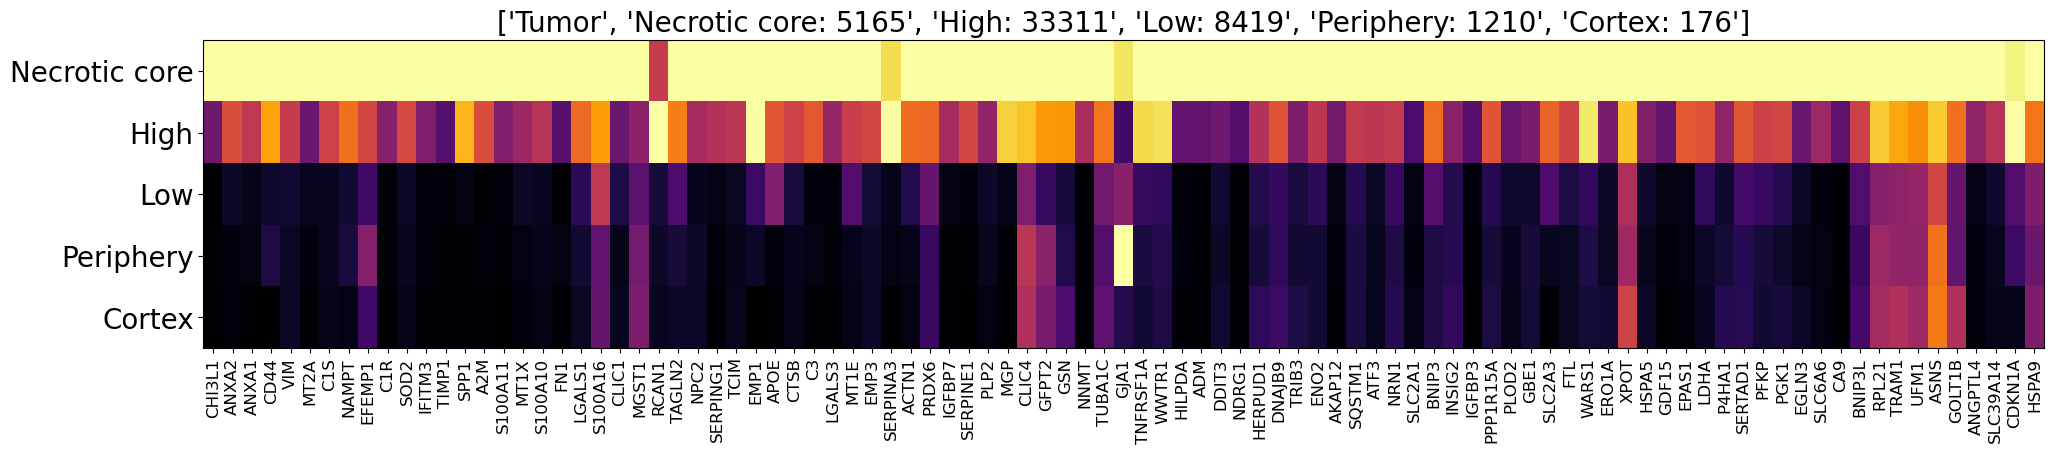

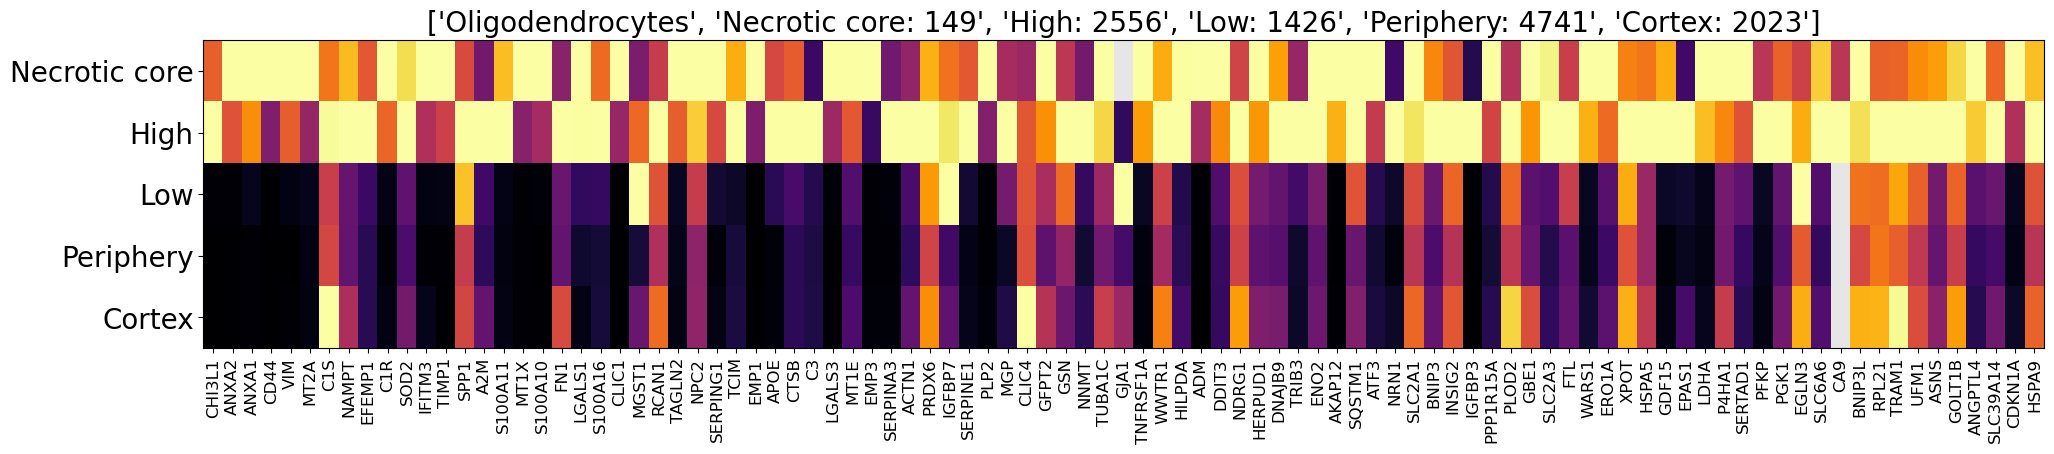

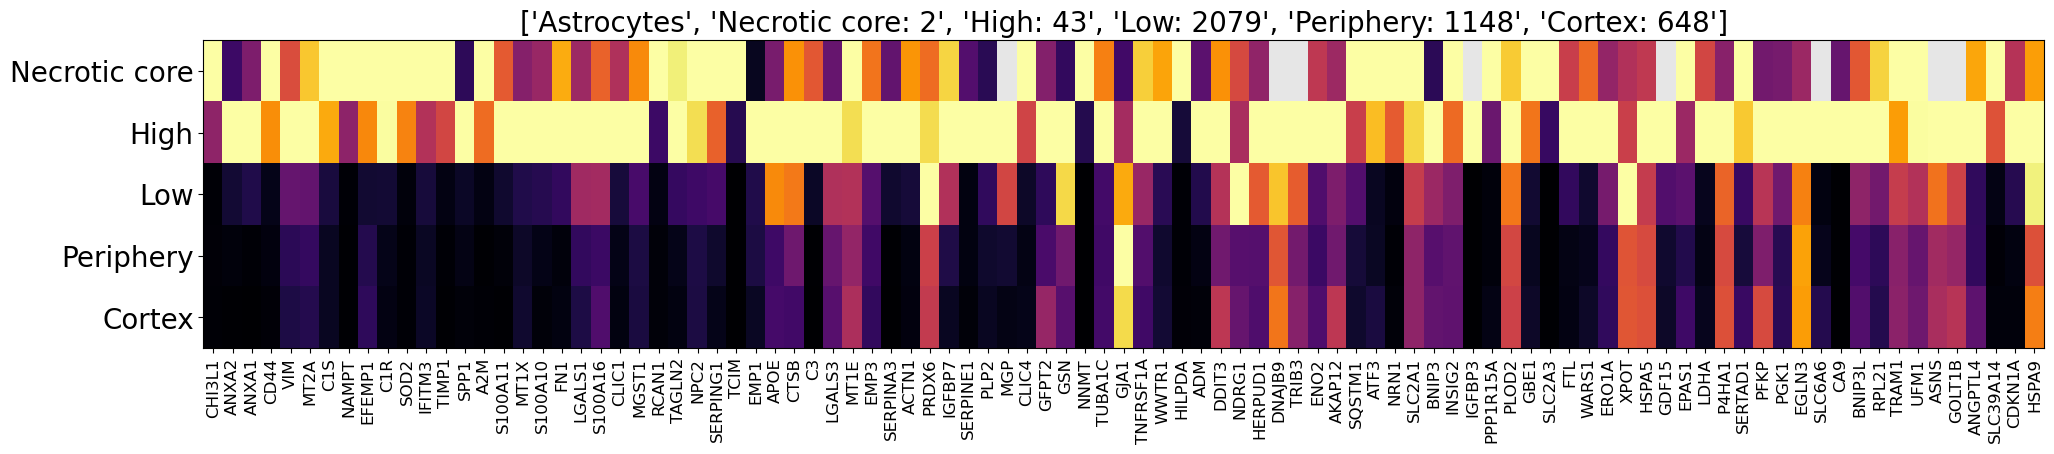

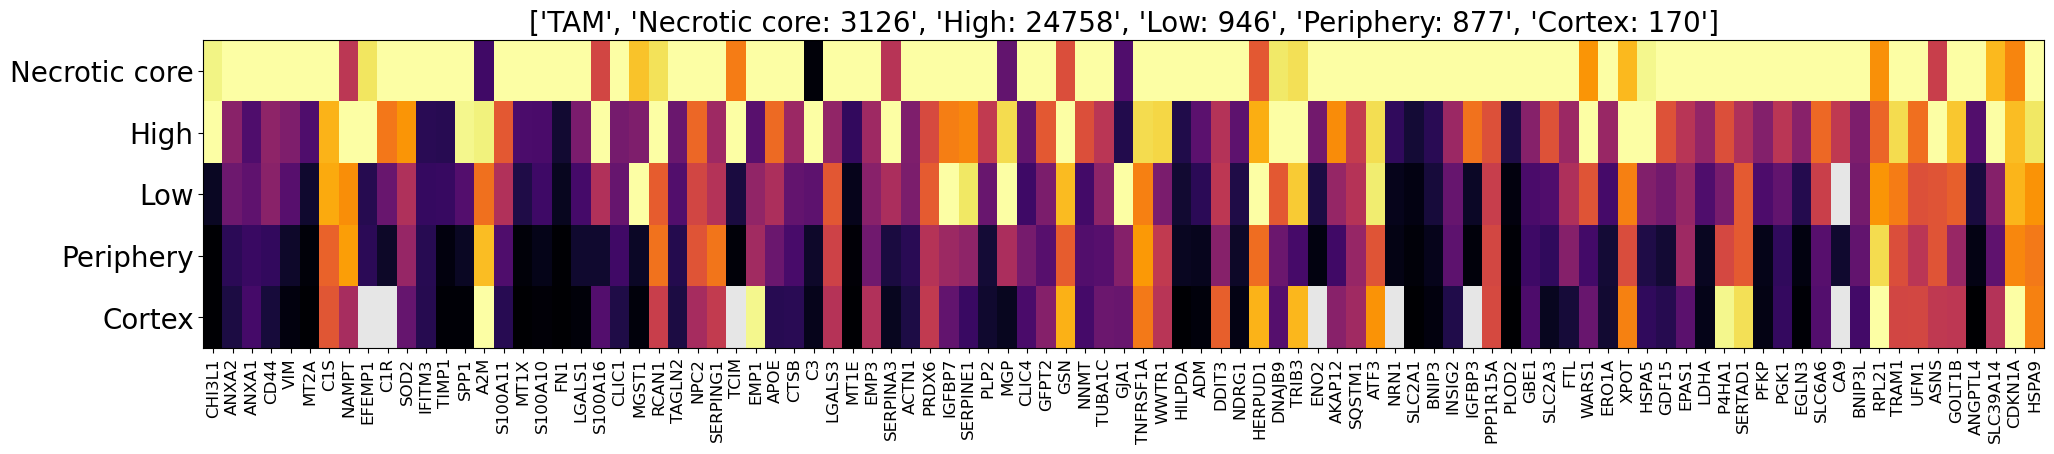

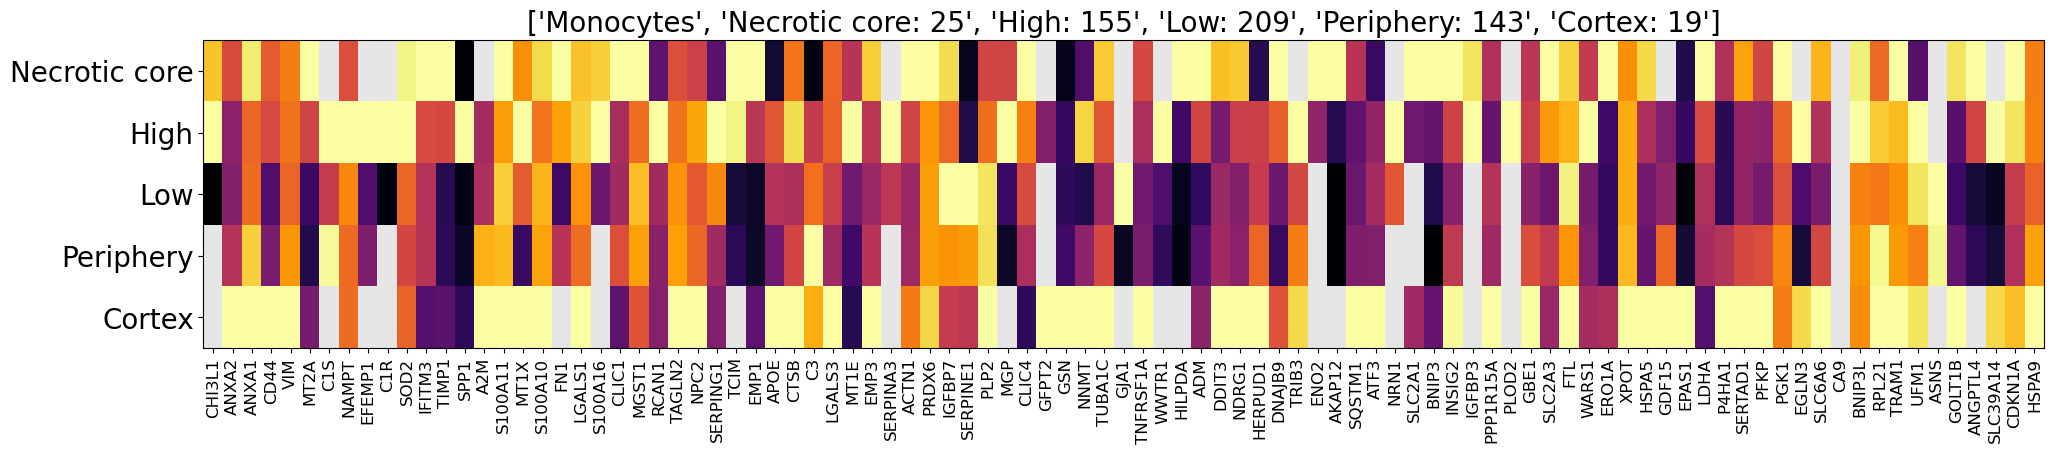

In [10]:
%%time
#Heatmap for all cell types, normalized internally, inferno
celltype = ['Tumor', 'Oligodendrocytes', 'Astrocytes', 'TAM', 'Monocytes']
Samples = ['Necrotic core', 'High', 'Low', 'Periphery', 'Cortex']
Samples = np.array(Samples, dtype=object)
for cell in celltype:
    Sum = [cell]
    unique_samples = []
    for i, sample in enumerate(Samples):
        Su = np.sum(ws.ManualAnnotationSL040_TAM[ws.Fluorescence[:] == sample] == cell)
        Sum.append(sample + ": " + str(Su))
        if Su > 0:
            unique_samples.append(sample)
    n_genes = len(gene_list)
    n_clusters = len(unique_samples)
    x = np.zeros((n_genes, n_clusters))
    for i, gene in enumerate(gene_list):
        gene_ix = np.where(ws.Gene[:] == gene)[0][0]
        for n, sample in enumerate(unique_samples):
            x[i, n] = np.mean(ws.Expression[:, ws.Gene == str(gene)][ws.Fluorescence[:] == sample][ws.ManualAnnotationSL040_TAM[ws.Fluorescence[:] == sample] == cell])

    # Normalize
    totals = x.sum(axis=1)
    xY = (x.T / totals * np.median(totals)).T
    xY = cg.div0(xY.T, np.percentile(xY, 99.5, axis=1)).T

    # Make background grey for zeros
    xY = xY.T
    G = xY
    bg = np.zeros_like(xY) + 0.9
    xY = np.ma.masked_where(xY == 0, xY)
    plt.figure(None, (n_genes / 4, 4))
    plt.imshow(bg[:], vmin=0, vmax=1, cmap=plt.cm.gray, aspect="auto")
    plt.imshow(xY[:], cmap="inferno", vmax=1, interpolation= "nearest", aspect="auto", alpha=1)
    plt.xticks(ticks=range(n_genes),labels=gene_list, fontsize=12, rotation=90)
    plt.yticks(ticks=range(n_clusters), labels=unique_samples, fontsize=20)
    plt.title(list(Sum),fontsize=20)
    None
    #plt.savefig("/proj/cytograph/jesper/Figures/Suppl/Heatmap_MES_" + cell + "wCortex.pdf",dpi=300, bbox_inches="tight")

CPU times: user 15min 36s, sys: 3min 50s, total: 19min 27s
Wall time: 25min 40s


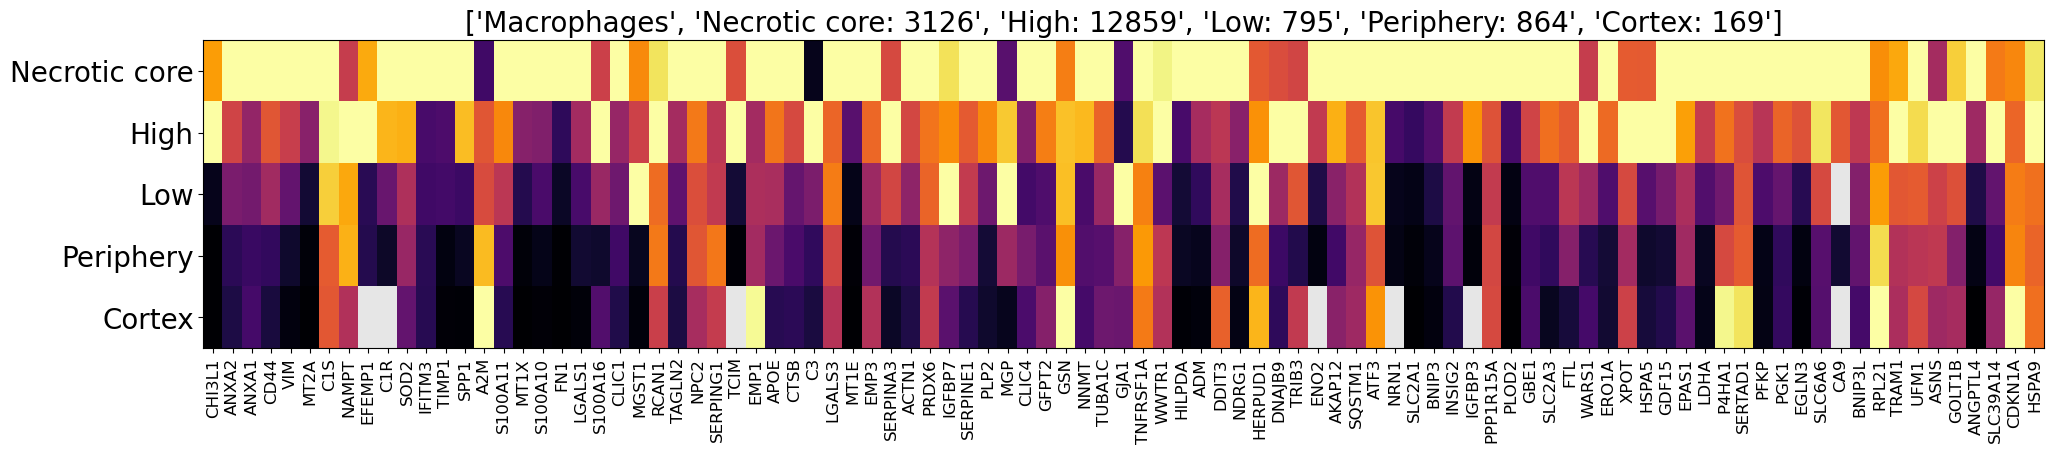

In [34]:
%%time
#TAM with cortex inferno
celltype = ['Macrophages']
#Samples = ['Ant high fluo', 'Ant low fluo', 'Ant no fluo'] 
Samples = ['Necrotic core', 'High', 'Low', 'Periphery','Cortex']
for cell in celltype:
    Sum = [cell]
    unique_samples = []
    for i, sample in enumerate(Samples):
        Su = np.sum(ws.ManualAnnotationSL040_Myeloid2[ws.Fluorescence[:] == sample] == cell)
        Sum.append(sample + ": " + str(Su))
        if Su > 0:
            unique_samples.append(sample)
    n_genes = len(gene_list)
    n_clusters = len(Samples)
    x = np.zeros((n_genes, n_clusters))
    for i, gene in enumerate(gene_list):
        gene_ix = np.where(ws.Gene[:] == gene)[0][0]
        for n, sample in enumerate(Samples):
            x[i, n] = np.mean(ws.Expression[:, ws.Gene == str(gene)][ws.Fluorescence[:] == sample][ws.ManualAnnotationSL040_Myeloid2[ws.Fluorescence[:] == sample] == 'Macrophages'])

    # Normalize
    totals = x.sum(axis=1)
    xY = (x.T / totals * np.median(totals)).T
    xY = cg.div0(xY.T, np.percentile(xY, 99.5, axis=1)).T

    # Make background grey for zeros
    xY = xY.T
    bg = np.zeros_like(xY) + 0.9
    xY = np.ma.masked_where(xY == 0, xY)
    plt.figure(None, (n_genes / 4, 4))
    plt.imshow(bg[:], vmin=0, vmax=1, cmap=plt.cm.gray, aspect="auto")
    plt.imshow(xY[:], cmap="inferno",vmin=0, vmax=1, interpolation="nearest", aspect="auto", alpha=1)
    plt.xticks(ticks=range(n_genes),labels=gene_list, fontsize=12, rotation=90)
    plt.yticks(ticks=range(n_clusters), labels=Samples, fontsize=20)
    #plt.savefig("/proj/cytograph/jesper/Figures/Suppl/Heatmap_non_normalized_macrophages_moTAM_SL040.pdf",dpi=300, bbox_inches="tight")
    plt.title(list(Sum),fontsize=20)
    None

CPU times: user 12min 53s, sys: 3min 6s, total: 15min 59s
Wall time: 20min 53s


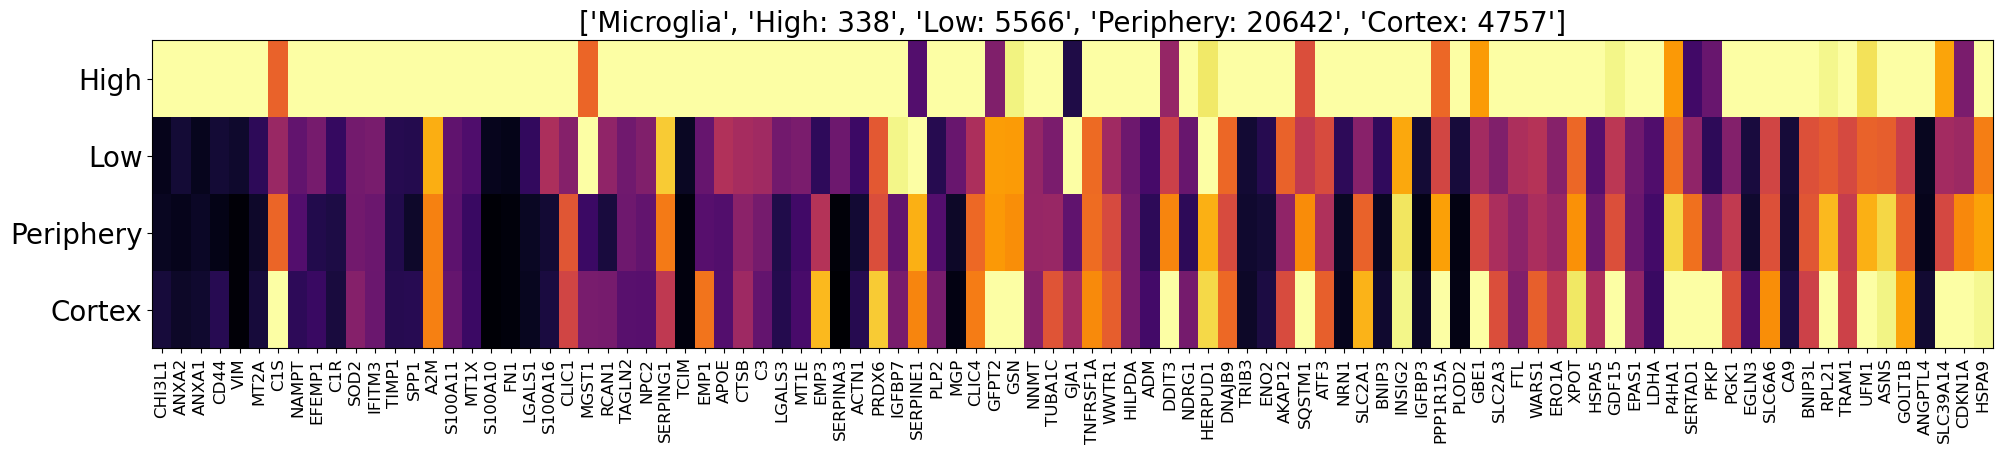

In [33]:
%%time
#TAM with cortex inferno
#celltype = np.unique(ws.ManualAnnotationSL040[:])
#Samples = ['Ant high fluo', 'Ant low fluo', 'Ant no fluo'] 
celltype = ['Microglia']
Samples = ['High', 'Low', 'Periphery','Cortex']
for cell in celltype:
    Sum = [cell]
    unique_samples = []
    for i, sample in enumerate(Samples):
        Su = np.sum(ws.ManualAnnotationSL040_TAM[ws.Fluorescence[:] == sample] == cell)
        Sum.append(sample + ": " + str(Su))
        if Su > 0:
            unique_samples.append(sample)
    n_genes = len(gene_list)
    n_clusters = len(Samples)
    x = np.zeros((n_genes, n_clusters))
    for i, gene in enumerate(gene_list):
        gene_ix = np.where(ws.Gene[:] == gene)[0][0]
        for n, sample in enumerate(Samples):
            x[i, n] = np.mean(ws.Expression[:, ws.Gene == str(gene)][ws.Fluorescence[:] == sample][ws.ManualAnnotationSL040_Myeloid2[ws.Fluorescence[:] == sample] == 'Microglia'])

    # Normalize
    totals = x.sum(axis=1)
    xY = (x.T / totals * np.median(totals)).T
    xY = cg.div0(xY.T, np.percentile(xY, 99.5, axis=1)).T

    # Make background grey for zeros
    xY = xY.T
    bg = np.zeros_like(xY) + 0.9
    xY = np.ma.masked_where(xY == 0, xY)
    plt.figure(None, (n_genes / 4, 4))
    plt.imshow(bg[:], vmin=0, vmax=1, cmap=plt.cm.gray, aspect="auto")
    plt.imshow(xY[:], cmap="inferno",vmin=0, vmax=1, interpolation="nearest", aspect="auto", alpha=1)
    plt.xticks(ticks=range(n_genes),labels=gene_list, fontsize=12, rotation=90)
    plt.yticks(ticks=range(n_clusters), labels=Samples, fontsize=20)
    #plt.savefig("/proj/cytograph/jesper/Figures/Suppl/Heatmap_non_normalized_microglia_mgTAM_SL040.pdf",dpi=300, bbox_inches="tight")
    plt.title(list(Sum),fontsize=20)
    None

In [36]:
adata = sc.read_h5ad("/proj/cytograph/jesper/GBM_SL040")

In [37]:
adata.var_names_make_unique()

In [38]:
adata.var["chromosome"] = adata.var["Chromosome"]
adata.var["start"] = adata.var["Start"]
adata.var["end"] = adata.var["End"]
adata.var["ensg"] = adata.var["Accession_copy"]

In [39]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [40]:
cnv.tl.infercnv(adata, window_size=500, exclude_chromosomes=('', 'GL000009.2', 'GL000194.1', 'GL000195.1', 'GL000205.2',
       'GL000213.1', 'GL000216.2', 'GL000218.1', 'GL000219.1',
       'GL000220.1', 'GL000225.1', 'KI270442.1', 'KI270711.1',
       'KI270713.1', 'KI270721.1', 'KI270726.1', 'KI270727.1',
       'KI270728.1', 'KI270731.1', 'KI270733.1', 'KI270734.1',
       'KI270744.1', 'KI270750.1','chrM','chrY'), reference_key="ManualAnnotationSL040",reference_cat=["Astrocytes", "Microglia","MgTAM", "Oligodendrocytes", "Endothelial"])

  0%|          | 0/28 [00:00<?, ?it/s]

{'heatmap_ax': <Axes: >,
 'groupby_ax': <Axes: ylabel='AneuploidMeta2'>,
 'gene_groups_ax': <Axes: >}

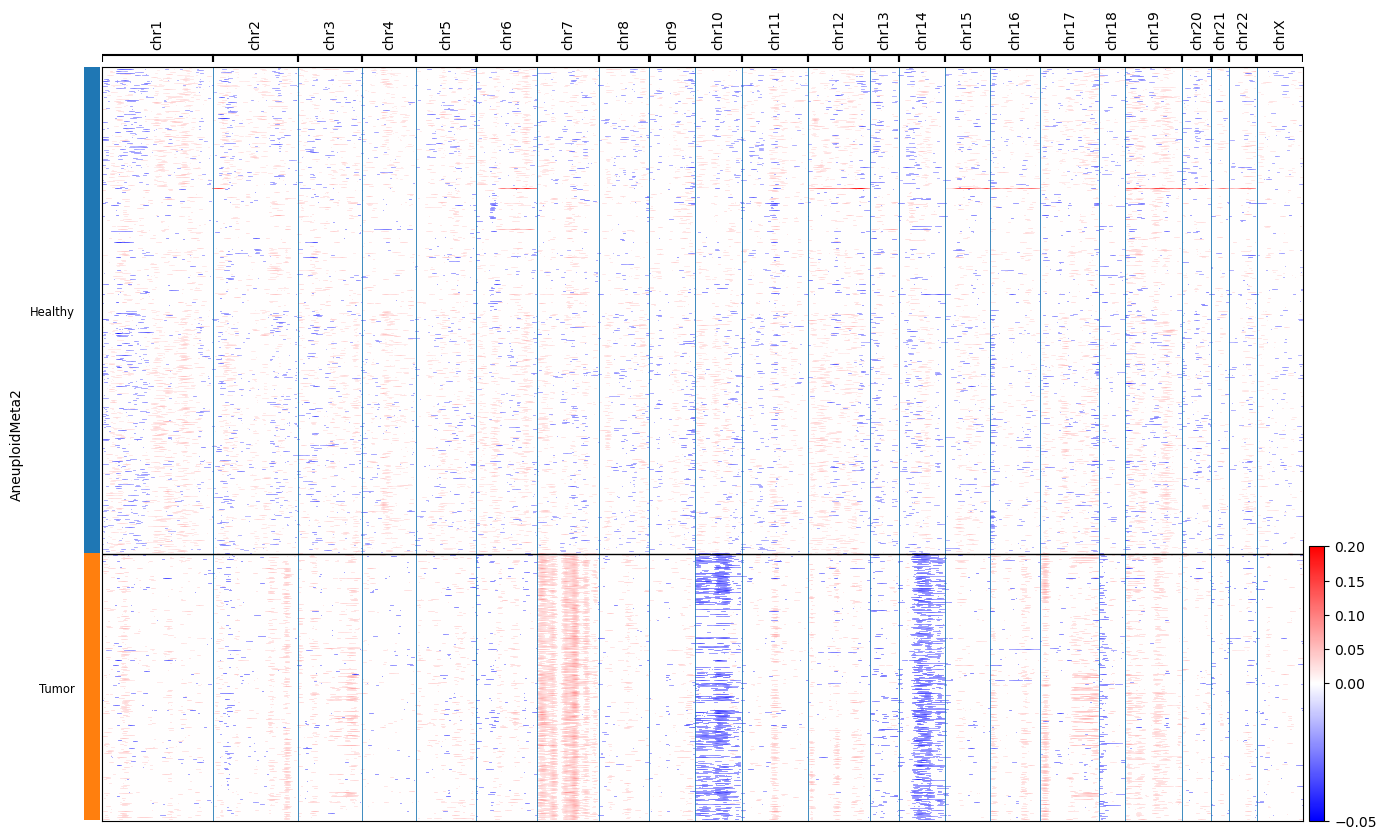

In [41]:
cnv.pl.chromosome_heatmap(adata, groupby="AneuploidMeta2", show=False, cmap='bwr',vmin = -0.05, vmax = 0.2)
#plt.savefig("/proj/cytograph/jesper/Figures/Fig1_SL040/SL040_inferCNV_ln.pdf", dpi=300, bbox_inches="tight")

In [17]:
palette_classes = {'Astrocytes':'#4574b3',
 'B-cells': [0.0, 0.45703125, 0.859375],
 'Endothelial': [0.59765625, 0.24609375, 0.0],
 'Fibroblasts': [0.296875, 0.0, 0.359375],
 'Macrophages': "#c7bd80",
 'Microglia': "#ee7c0e",
 'MoTAM': [0.99609375, 0.796875, 0.59765625], 
 'MgTAM':  "#b36305",                
 'Monocytes': "#a580ad",
 'OPCs': [0.55859375, 0.484375, 0.0],
 'Oligodendrocytes': "#000000",
 'Pericytes': [0.7578125, 0.0, 0.53125],
 'Tumor': "#74c493",
 'VSMC': [0.99609375, 0.640625, 0.01953125]}

In [19]:
annotation_palette = {
'Astrocytes': '#4574B3',#'#3fc380',
'Oligodendrocytes':'#000000',

'B-cells': '#808080',
'Endothelial':'#808080',#'#fef160',
'Fibroblasts':'#808080',
'NK, T-cells':'#808080',
'OPCs':'#808080',
'Pericytes':'#808080',
'VSMC':'#808080',

'MgTAM':'#B36305',#'#d2d7d3',
'MoTAM':'#FECB98',#'#d
'Microglia':'#EE7C0E',
'Monocytes':'#A580AD',
'Neuron':'#fabe58',
'Macrophages':'#C7BD80',

'Tumor':'#74C493',#'#e76d89',
}

In [7]:
adata = sc.read_h5ad("/proj/cytograph/jesper/GBM_SL040")

In [10]:
adata = ws.create_anndata()

In [11]:
adata

AnnData object with n_obs × n_vars = 135482 × 59480
    obs: 'Age', 'AneuploidMeta', 'AneuploidMeta2', 'Aneuploid_Manual', 'Aneuploid_expression', 'CellCycleFraction', 'Celltype', 'Chemistry', 'Clones', 'Clones2', 'ClonesAbberations', 'ClonesAbberations2', 'Clusters', 'ClustersProbability', 'ClustersSecondary', 'ClustersSecondaryProbability', 'Direction', 'Dissociation', 'Donor', 'DoubletFlag', 'DoubletScore', 'Fluorescence', 'GBmapPredicted', 'KaryotypeBestReference', 'KaryotypeCellOrdering', 'KaryotypeMetacells', 'Location', 'ManualAnnotation', 'ManualAnnotationSL040', 'ManualAnnotationSL040_LevelFinal', 'ManualAnnotationSL040_MAC', 'ManualAnnotationSL040_Myeloid', 'ManualAnnotationSL040_Myeloid2', 'ManualAnnotationSL040_TAM', 'ManualAnnotationSL040_TAM2', 'ManualAnnotationSL040_Vasc', 'ManualAnnotationSL040_central_peri', 'ManualAnnotationSample', 'ManualAnnotationSample_new', 'Metacells', 'MitoFraction', 'NGenes', 'NeftelClass', 'PrevClusters', 'PrevPrevClusters', 'Sample', 'Sample

In [12]:
Emb = ws.Embedding[:]
Emb

array([[-52.86618  ,  10.3990555],
       [-18.878757 , -25.164074 ],
       [-19.028446 , -23.991652 ],
       ...,
       [ 29.549313 , -18.995222 ],
       [ 20.53669  ,   8.008962 ],
       [ 22.308754 ,  -1.0486426]], dtype=float32)

In [23]:
adata.obsm["X_tsne"] = Emb

In [15]:
adata

AnnData object with n_obs × n_vars = 135482 × 59480
    obs: 'Age', 'AneuploidMeta', 'AneuploidMeta2', 'Aneuploid_Manual', 'Aneuploid_expression', 'CellCycleFraction', 'Celltype', 'Chemistry', 'Clones', 'Clones2', 'ClonesAbberations', 'ClonesAbberations2', 'Clusters', 'ClustersProbability', 'ClustersSecondary', 'ClustersSecondaryProbability', 'Direction', 'Dissociation', 'Donor', 'DoubletFlag', 'DoubletScore', 'Fluorescence', 'GBmapPredicted', 'KaryotypeBestReference', 'KaryotypeCellOrdering', 'KaryotypeMetacells', 'Location', 'ManualAnnotation', 'ManualAnnotationSL040', 'ManualAnnotationSL040_LevelFinal', 'ManualAnnotationSL040_MAC', 'ManualAnnotationSL040_Myeloid', 'ManualAnnotationSL040_Myeloid2', 'ManualAnnotationSL040_TAM', 'ManualAnnotationSL040_TAM2', 'ManualAnnotationSL040_Vasc', 'ManualAnnotationSL040_central_peri', 'ManualAnnotationSample', 'ManualAnnotationSample_new', 'Metacells', 'MitoFraction', 'NGenes', 'NeftelClass', 'PrevClusters', 'PrevPrevClusters', 'Sample', 'Sample

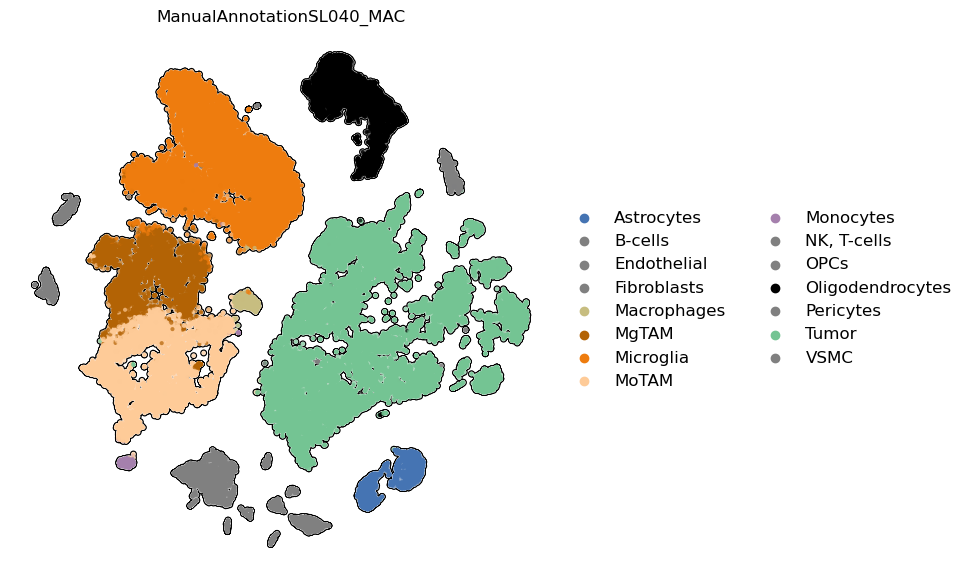

In [25]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))

sc.pl.tsne(
adata,
color='ManualAnnotationSL040_MAC',
add_outline=True,
size=35,
#legend_loc="on data",
legend_fontsize=12,
legend_fontoutline=2,
frameon=False,
palette=annotation_palette,
ax=ax,
show=False,
#save='figures/AnnotationUMAP.pdf',
)
plt.savefig("/proj/cytograph/jesper/Figures/Fig1_SL040/SL040_tSNE_colors_new.png",format='png', dpi=300,transparent=True)
plt.show()

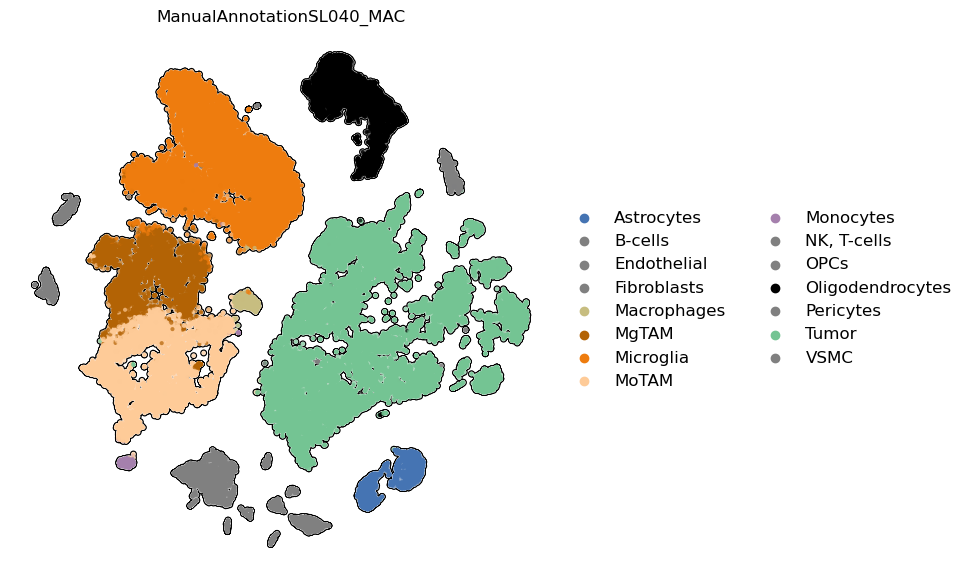

In [21]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(7,7))

sc.pl.umap(
adata,
color='ManualAnnotationSL040_MAC',
add_outline=True,
size=35,
#legend_loc="on data",
legend_fontsize=12,
legend_fontoutline=2,
frameon=False,
palette=annotation_palette,
ax=ax,
show=False,
#save='figures/AnnotationUMAP.pdf',
)


#plt.savefig('figures/AnnotationUMAP.png',format='png', dpi=300,transparent=True)
plt.show()